In [ ]:
import numpy as np
import time
#import cupy as cp
import matplotlib.pyplot as plt

### Algorithms

### Compression

In [ ]:
def printzz(MPS,string=''):
  print(string,end=': ')
  for i in range(len(MPS)):
    print(MPS[i].shape, end=' ')
  print()

In [ ]:
def Compression_SVD(MPS,max_m):
  MPS_new=[MPS[0]]
  
  for i in range(N-1):
    m1=MPS_new[i].shape[0]
    m2=MPS[i+1].shape[-1]

    temp=np.tensordot(MPS_new[i],MPS[i+1],axes=([-1],[0]))
    temp=temp.reshape((m1*d,m2*d))
    U,S,Vh=np.linalg.svd(temp)
    m=min(np.sum((S/S[0])>1e-8), max_m)

    U=U[:,:m]
    Vh=Vh[:,:m]
    S=S[:m]

    U=U@np.diag(S)

    U=U.reshape((m1,d,m))
    Vh=Vh.reshape((m,d,m2))

    MPS_new.pop()
    MPS_new.append(U)
    MPS_new.append(Vh)

  MPS2=[MPS_new[-1]]
  for i in range(N-1):
    m1=MPS_new[N-i-2].shape[0]
    m2=MPS2[0].shape[-1]
    
    temp=np.tensordot(MPS_new[N-i-2],MPS2[0],axes=([-1],[0]))
    temp=temp.reshape((m1*d,m2*d))
    U,S,Vh=np.linalg.svd(temp)
    m=min(np.sum((S/S[0])>1e-8), max_m)

    U=U[:,:m]
    Vh=Vh[:,:m]
    S=S[:m]

    U=U@np.diag(S)

    U=U.reshape((m1,d,m))
    Vh=Vh.reshape((m,d,m2))

    del MPS2[0]
    MPS2.insert(0,Vh)
    MPS2.insert(0,U)

  return MPS2

Solve the minimization problem
$$\min_\psi \langle \psi -\phi | \psi - \phi \rangle = \min_\phi [-2 \langle \phi | \psi \rangle + \langle \phi | \phi \rangle]$$
where $\psi$ is the original MPS and $\phi$ is the new MPS.

In [ ]:
#Using variational Compression Algorithm
def Compression(psi,max_m):
  phi=Compression_SVD(MPS,max_m)
  printzz(phi,"phi")

  phi[0]=phi[0][0]
  psi[0]=psi[0][0]
  phi[N-1]=phi[N-1][:,:,0]
  psi[N-1]=psi[N-1][:,:,0]
  
  Cr=[np.tensordot(phi[N-1],phi[N-1],axes=([1],[1]))]   #Stores partially computed <phi|phi> from right
  Dr=[np.tensordot(phi[N-1],psi[N-1],axes=([1],[1]))]   #Stores partially computed <phi|psi> from right
  
  for i in range(1,N-1):
    temp=np.tensordot(phi[N-i-1],Cr[-1],axes=([-1],[1]))
    temp=np.tensordot(phi[N-i-1],temp,axes=([1,-1],[1,-1]))
    Cr.append(temp)

    temp=np.tensordot(psi[N-i-1],Dr[-1],axes=([-1],[1]))
    temp=np.tensordot(phi[N-i-1],temp,axes=([1,-1],[1,-1]))
    Dr.append(temp)


  b=np.tensordot(psi[0],Dr[-1],axes=([-1],[1]))
  M=np.tensordot(np.identity(d),Cr[-1],axes=0)
  M=M.transpose([0,2,1,3])

  m=b.shape[-1] #Bond dimension

  b=b.reshape(-1) #initial shape (d,m)
  M=M.reshape((d*m,d*m)) #initial shape (d,m,d,m)
  a=np.linalg.lstsq(M,b,rcond=None) 
  a=a[0]
  a=np.reshape(a,(d,m))

  MPS_res=[a]

  Cl=[np.tensordot(MPS_res[0],MPS_res[0],axes=([0],[0]))]   #Stores partially computed <phi|phi> from left
  Dl=[np.tensordot(MPS_res[0],psi[0],axes=([0],[0]))]   #Srores partially computed <phi|psi> from left

  for i in range(1,N-1):
    temp=np.tensordot(psi[i],Dr[-i-1],axes=([-1],[1]))
    b=np.tensordot(Dl[-1],temp,axes=([1],[0]))
    print(b.shape)  

    temp=np.tensordot(np.identity(d),Cr[-i-1],axes=0)
    M=np.tensordot(Cl[-1],temp,axes=0)
    M=M.transpose([0,2,4,1,3,5])

    #Bond dimensions
    m1=b.shape[0]
    m2=b.shape[-1] 

    b=b.reshape(-1) #initial shape (m1,d,m2)
    M=M.reshape((m1*d*m2,m1*d*m2)) #initial shape (m1,d,m2,m1,d,m2)
    a=np.linalg.lstsq(M,b,rcond=None)
    a=a[0]
    a=np.reshape(a,(m1,d,m2))

    MPS_res.append(a)

    temp=np.tensordot(Cl[-1],MPS_res[-1],axes=([1],[0]))
    temp=np.tensordot(MPS_res[-1],temp,axes=([0,1],[0,1]))
    Cl.append(temp)

    temp=np.tensordot(Dl[-1],psi[i],axes=([1],[0]))
    temp=np.tensordot(phi[i],temp,axes=([0,1],[0,1]))
    Dl.append(temp)

  b=np.tensordot(Dl[-1],psi[-1],axes=([1],[0]))
  print(b.shape)

  M=np.tensordot(Cl[-1],np.identity(d),axes=0)
  M=M.transpose([0,2,1,3])

  m=b.shape[0] #Bond dimension

  b=b.reshape(-1) #initial shape (m1,d)
  M=M.reshape((m*d,m*d)) #initial shape (m,d,m,d)
  a=np.linalg.lstsq(M,b,rcond=None)
  a=a[0]
  a=np.reshape(a,(m,d))

  MPS_res.append(a)

  m=MPS_res[0].shape[-1]
  MPS_res[0]=np.reshape(MPS_res[0],(1,d,m))
  m=MPS_res[-1].shape[0]
  MPS_res[-1]=np.reshape(MPS_res[-1],(m,d,1))

  return MPS_res

In [ ]:
N=10
m=5         #Initial Bond dimension of MPS
m_max=64    #Maximum Bond Dimension
d=2         
key=np.random.choice([0,1],size=10)

MPS=[(np.random.rand(1,d,m)-0.5)+1j*(np.random.rand(1,d,m)-0.5)]
for i in range(N-2):
  local_state=(np.random.rand(m,d,m)-0.5)+1j*(np.random.rand(m,d,m)-0.5)
  MPS.append(local_state)
MPS.append((np.random.rand(m,d,1)-0.5)+1j*(np.random.rand(m,d,1)-0.5))

In [ ]:
MPS_res=Compression(MPS, 64)
printzz(MPS_res,"MPS_res")

phi: (1, 2, 2) (2, 2, 4) (4, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 4) (4, 2, 2) (2, 2, 1) 
(2, 2, 4)
(4, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 4)
(4, 2, 2)
(2, 2)
MPS_res: (1, 2, 2) (2, 2, 4) (4, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 5) (5, 2, 4) (4, 2, 2) (2, 2, 1) 


### Evaluation
$O(N m^3)$

In [ ]:
def Evaluate(MPS,key,N):
  MPS1=MPS[0][:,key[0],:]

  for i in range(N-1):
    MPS2=MPS[i+1][:,key[i+1],:]
    MPS_cont=np.tensordot(MPS1,MPS2,axes=([-1],[0]))
    MPS1=MPS_cont
  return MPS1

$O(Nm^3 d)$

In [ ]:
def Overlap(MPS1,MPS2,N):
  res=0
  for i in range(N-1):
    MPS2=MPS[i+1][:,key[i+1],:]
    MPS_cont=np.tensordot(MPS1,MPS2,axes=([-1],[0]))
    MPS1=MPS_cont
  return MPS1

### Addition:  
$O(N d m^2)$

In [ ]:
def Add_MPS(MPS1, MPS2, N):
  MPS_res = []
  for i in range(N):
    m1_left=np.shape(MPS1[i])[0]
    m1_right=np.shape(MPS1[i])[-1]
    m2_left=np.shape(MPS2[i])[0]
    m2_right=np.shape(MPS2[i])[-1]

    if i==0:
      temp=np.zeros((1, d, m1_right + m2_right)).astype('complex')
      temp[:,:,:m1_right]=MPS1[i]
      temp[:,:,m1_right:]=MPS2[i]
      MPS_res.append(temp)
      continue
    
    if i==N-1:
      temp=np.zeros((m1_left + m2_left, d, 1)).astype('complex')
      temp[:m1_left,:,:]=MPS1[i]
      temp[m1_left:,:,:]=MPS2[i]
      MPS_res.append(temp)
      continue

    temp=np.zeros((m1_left + m2_left, d, m1_right + m2_right)).astype('complex')
    temp[:m1_left,:,:m1_right]=MPS1[i]
    temp[m1_left:,:,m1_right:]=MPS2[i]
    MPS_res.append(temp)
  return MPS_res

def Add_MPO(MPO1, MPO2, N):
  MPO_res = []
  for i in range(N):
    m1_left=np.shape(MPO1[i])[0]
    m1_right=np.shape(MPO1[i])[-1]
    m2_left=np.shape(MPO2[i])[0]
    m2_right=np.shape(MPO2[i])[-1]

    if i==0:
      temp=np.zeros((1, d, d, m1_right + m2_right)).astype('complex')
      temp[:,:,:,:m1_right]=MPO1[i]
      temp[:,:,:,m1_right:]=MPO2[i]
      MPO_res.append(temp)
      continue
    
    if i==N-1:
      temp=np.zeros((m1_left + m2_left, d, d, 1)).astype('complex')
      temp[:m1_left,:,:,:]=MPO1[i]
      temp[m1_left:,:,:,:]=MPO2[i]
      MPO_res.append(temp)
      continue

    temp=np.zeros((m1_left + m2_left, d, d, m1_right + m2_right)).astype('complex')
    temp[:m1_left,:,:,:m1_right]=MPO1[i]
    temp[m1_left:,:,:,m1_right:]=MPO2[i]
    MPO_res.append(temp)
  return MPO_res

In [ ]:
m=10
psi1=[np.random.rand(1,2,2,m),np.random.rand(m,2,2,m),np.random.rand(m,2,2,m),np.random.rand(m,2,2,1)]
psi2=[np.random.rand(1,2,2,m),np.random.rand(m,2,2,m),np.random.rand(m,2,2,m),np.random.rand(m,2,2,1)]

psi_res=Add_MPO(psi1,psi2,4)

In [ ]:
temp1=psi1[0]
temp2=psi2[0]
temp_res=psi_res[0]
for i in range(3):
  temp1=np.tensordot(temp1,psi1[i+1],axes=([-1],[0]))
  temp2=np.tensordot(temp2,psi2[i+1],axes=([-1],[0]))
  temp_res=np.tensordot(temp_res,psi_res[i+1],axes=([-1],[0]))

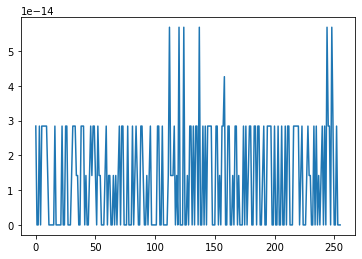

In [ ]:
plt.plot(np.abs(np.reshape(temp_res - (temp1+temp2),-1)))

### MPO_MPS
$O(N d^2 m^4)$

In [ ]:
def MPO_MPS(MPO, MPS):
  MPS_res=[]
  for i in range(N):
    MPS_res.append(np.tensordot(MPO[i],MPS[i],axes=([1],[1])))

### Hamiltonian

In [ ]:
sig_x=np.array([[0,1],[1,0]])
sig_y=np.array([[0,-1j],[1j,0]])
sig_z=np.array([[1,0],[0,-1]])

In [ ]:
sig_xx=np.tensordot(sig_x, sig_x, axes=0)
sig_yy=np.tensordot(sig_y, sig_y, axes=0)
sig_zz=np.tensordot(sig_z, sig_z, axes=0)

H2=(sig_xx+sig_yy+sig_zz)/2

In [ ]:
def MPO(N):
  MPO=[]
  first=np.array([np.zeros((2,2)), sig_x, sig_y, sig_z, np.identity(2)])
  first=first.transpose([1,2,0])
  last=np.array([np.identity(2), sig_x/2, sig_y/2, sig_z/2, np.zeros((2,2))])
  inter=np.zeros((5,2,2,5)).astype('complex')

  inter[-1,:,:,:]=first
  inter[:,:,:,0]=last

  MPO.append(first.reshape(1,2,2,5))
  for i in range(N-2):
    MPO.append(inter)
  MPO.append(last.reshape(5,2,2,1))

  return MPO

In [ ]:
temp=MPO(N)

for i in range(N):
  print(temp[i].shape)

(1, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 1)


In [ ]:
#Old Approach
'''
def MPO(N):
  if N%2==1: print("Warning: Odd system size!")

  U,S,Vh=np.linalg.svd(H2.reshape(4,4))
  #U=U[:,:3]
  #Vh=Vh[:3,:]
  #S=S[:3]
  #print(U,'\n',S,'\n',Vh)

  U=U@np.diag(S) #Left Canonical

  U=np.reshape(U,(1,d,d,4))
  Vh=np.reshape(Vh,(4,d,d,1))

  MPO_odd=[]
  MPO_even=[np.reshape(np.identity(d),(1,d,d,1))]
  
  for i in range(N-1):
    if i%2==0:
      MPO_odd.append(U)
      MPO_odd.append(Vh)
    else:
      MPO_even.append(U)
      MPO_even.append(Vh)

  MPO_even.append(np.reshape(np.identity(d),(1,d,d,1)))
  return Add_MPO(MPO_odd, MPO_even, N)
'''

'\ndef MPO(N):\n  if N%2==1: print("Warning: Odd system size!")\n\n  U,S,Vh=np.linalg.svd(H2.reshape(4,4))\n  #U=U[:,:3]\n  #Vh=Vh[:3,:]\n  #S=S[:3]\n  #print(U,\'\n\',S,\'\n\',Vh)\n\n  U=U@np.diag(S) #Left Canonical\n\n  U=np.reshape(U,(1,d,d,4))\n  Vh=np.reshape(Vh,(4,d,d,1))\n\n  MPO_odd=[]\n  MPO_even=[np.reshape(np.identity(d),(1,d,d,1))]\n  \n  for i in range(N-1):\n    if i%2==0:\n      MPO_odd.append(U)\n      MPO_odd.append(Vh)\n    else:\n      MPO_even.append(U)\n      MPO_even.append(Vh)\n\n  MPO_even.append(np.reshape(np.identity(d),(1,d,d,1)))\n  return Add_MPO(MPO_odd, MPO_even, N)\n'

In [ ]:
H4=MPO(4)
temp=H4[0]
for i in range(3):
  temp=np.tensordot(temp,H4[i+1],axes=([-1],[0]))
temp.shape

(1, 2, 2, 2, 2, 2, 2, 2, 2, 1)

In [ ]:
for i in range(4):
  print(H4[i].shape)

(1, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 5)
(5, 2, 2, 1)


In [ ]:
temp=temp[0,:,:,:,:,:,:,:,:,0]
temp=np.reshape(np.transpose(temp,[0,2,4,6,1,3,5,7]),(2**4,2**4))

In [ ]:
H2X = (np.kron(sig_x,sig_x) + np.kron(sig_y,sig_y) + np.kron(sig_z,sig_z))/2

In [ ]:
H4X = H2X.copy()
for i in range(2):
  H4X=np.kron(H4X,np.identity(2))+np.kron(np.identity(H4X.shape[0]//2),H2X)

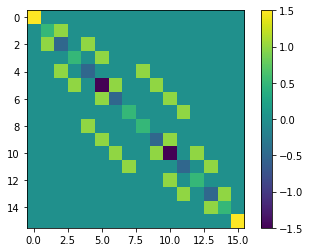

In [ ]:
plt.imshow(np.real(temp))
plt.colorbar()
plt.show()

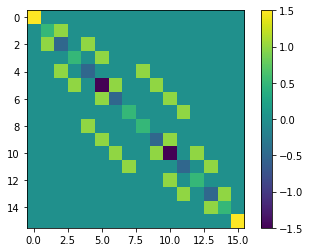

In [ ]:
plt.imshow(np.real(H4X))
plt.colorbar()
plt.show()

### AGSP

In [ ]:
AGSP=MPO(N)
AGSP[0]=-AGSP[0]

I_MPO=[np.reshape(np.identity(2),(1,2,2,1))]*N

AGSP=Add_MPO(I_MPO,AGSP,N)

In [ ]:
for i in range(N):
  print(AGSP[i].shape)

(1, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 6)
(6, 2, 2, 1)


### Main

In [ ]:
N=10
m=5         #Initial Bond dimension of MPS
m_max=64    #Maximum Bond Dimension
d=2         
key=np.random.choice([0,1],size=10)

MPS=[(np.random.rand(1,d,m)-0.5)+1j*(np.random.rand(1,d,m)-0.5)]
for i in range(N-2):
  local_state=(np.random.rand(m,d,m)-0.5)+1j*(np.random.rand(m,d,m)-0.5)
  MPS.append(local_state)
MPS.append((np.random.rand(m,d,1)-0.5)+1j*(np.random.rand(m,d,1)-0.5))

In [ ]:
MPS_new=Compression_SVD(MPS, 64)

(1, 2, 5) 
Yo:  (2, 2) (2,) (10, 10)
New Bond Dimension:  2
(1, 2, 2) (2, 2, 5) 
Yo:  (4, 4) (4,) (10, 10)
New Bond Dimension:  4
(1, 2, 2) (2, 2, 4) (4, 2, 5) 
Yo:  (8, 8) (8,) (10, 10)
New Bond Dimension:  8
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 5) 
Yo:  (16, 16) (10,) (10, 10)
New Bond Dimension:  10
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 10) (10, 2, 5) 
Yo:  (20, 20) (10,) (10, 10)
New Bond Dimension:  10
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 10) (10, 2, 10) (10, 2, 5) 
Yo:  (20, 20) (10,) (10, 10)
New Bond Dimension:  10
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 5) 
Yo:  (20, 20) (10,) (10, 10)
New Bond Dimension:  10
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 5) 
Yo:  (20, 20) (10,) (10, 10)
New Bond Dimension:  10
(1, 2, 2) (2, 2, 4) (4, 2, 8) (8, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 10) (10, 2, 5) 
Yo:  (20, 20) (2,) (2, 2)
New Bond Dimension:  2


### Testing

In [ ]:
from numpy import polynomial as Poly

P=np.flip(Poly.chebyshev.cheb2poly([0,0,0,0,0,0,1]))

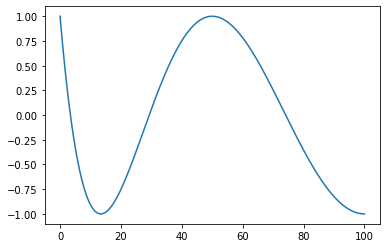

In [ ]:
u=100
e=0
x=np.arange(e,u,0.01)

y1=np.polyval(P,(u+e-x)/(u-e))/np.polyval(P,(u+e)/(u-e))
plt.plot(x,y1)